In [1]:
import datetime
import os
from pathlib import Path
import pickle
import random
from typing import Any, Dict, List, Tuple, Union

import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from natsort import natsorted
import numpy as np
import pandas as pd
import pytorch_lightning as L
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, StochasticWeightAveraging, TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from sklearn.model_selection import train_test_split
import timm
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchmetrics import Precision, Recall
from torchmetrics.functional.classification import multiclass_confusion_matrix, multiclass_f1_score

from configs.config import CFG
from model.multitask_unet import MultiTaskUNet
from util.get_logger import get_logger
from util.my_dataset import MyDataModule, MyDataset


os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
torch.set_float32_matmul_precision("high")

/home/ss/kaggle_work/.venv/lib/python3.11/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
class LitUNetModel(L.LightningModule):
    def __init__(
            self,
            model_name: str,
            pretrained: bool,
            num_classes: int,
            height: int,
            width: int,
            learning_rate: float,
            mean_y: torch.Tensor,
            std_y: torch.Tensor,
        ) -> None:

        super().__init__()
        self.model = MultiTaskUNet(model_name, num_classes, pretrained, height, width)
        self.num_classes = num_classes
        self.criterion1 = nn.L1Loss()
        self.criterion2 = nn.CrossEntropyLoss()
        self.learning_rate = learning_rate
        self.mean_y = mean_y
        self.std_y = std_y
        self.save_hyperparameters(ignore=["criterion1", "criterion2"])

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        reg_logit, clf_logit = self.model(x)
        pred_class = clf_logit.argmax(dim=1)
        mean_by_class = self.mean_y[pred_class]
        std_by_class = self.std_y[pred_class]
        reg_logit = reg_logit * std_by_class + mean_by_class
        reg_logit = torch.clip(reg_logit, min=1500, max=4500)
        return reg_logit, clf_logit

    def training_step(self, batch: Tuple[torch.Tensor, torch.Tensor, torch.Tensor]):
        x, y, label, _ = batch
        batch_size = len(x)
        reg_logit, clf_logit = self.forward(x)
        loss1 = self.criterion1(reg_logit, y)
        loss2 = self.criterion2(clf_logit, label)
        loss = loss1 + loss2
        self.log("train_loss1", loss1, on_step=True, on_epoch=True, prog_bar=True, logger=True, batch_size=batch_size)
        self.log("train_loss2", loss2, on_step=True, on_epoch=True, prog_bar=True, logger=True, batch_size=batch_size)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True, batch_size=batch_size)
        return loss
    
    def validation_step(self, batch: Tuple[torch.Tensor, torch.Tensor, torch.Tensor]):
        x, y, label, _ = batch
        batch_size = len(x)
        reg_logit, clf_logit = self.forward(x)
        loss1 = self.criterion1(reg_logit, y)
        loss2 = self.criterion2(clf_logit, label)
        loss = loss1 + loss2
        f1 = multiclass_f1_score(clf_logit, label, num_classes=self.num_classes, average="macro")
        self.log("val_loss1", loss1, on_step=True, on_epoch=True, prog_bar=True, logger=True, batch_size=batch_size)
        self.log("val_loss2", loss2, on_step=True, on_epoch=True, prog_bar=True, logger=True, batch_size=batch_size)
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True, batch_size=batch_size)
        self.log("val_f1", f1, on_step=True, on_epoch=True, prog_bar=True, logger=True, batch_size=batch_size)
        return loss
    
    def on_test_epoch_start(self):
        self.clf_targets = []
        self.clf_preds = []
        self.mae_all = 0
        self.num_data = 0
    
    def test_step(
            self,
            batch: Tuple[torch.Tensor, torch.Tensor, torch.Tensor],
            batch_idx: int
        ) -> Dict[str, float]:
        
        x, y, label, path = batch
        batch_size = len(x)
        reg_logit, clf_logit = self.forward(x)
        loss1 = F.l1_loss(reg_logit, y)
        loss2 = F.cross_entropy(clf_logit, label)
        loss = loss1 + loss2
        f1 = multiclass_f1_score(clf_logit, label, num_classes=self.num_classes, average="macro")
        self.mae_all += F.l1_loss(reg_logit, y, reduction="sum")
        self.num_data += len(x)

        self.clf_targets.append(label.cpu())
        self.clf_preds.append(clf_logit.argmax(dim=1).cpu())
        
        self.log("test_loss1", loss1, on_step=True, on_epoch=True, prog_bar=True, logger=True, batch_size=batch_size)
        self.log("test_loss2", loss2, on_step=True, on_epoch=True, prog_bar=True, logger=True, batch_size=batch_size)
        self.log("test_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True, batch_size=batch_size)
        self.log("test_f1", f1, on_step=True, on_epoch=True, prog_bar=True, logger=True, batch_size=batch_size)

        if batch_idx == 0:
            print(path[0])
            _, axs = plt.subplots(1, 8, figsize=(32, 8))
            for i in range(5):
                im0 = axs[i].imshow(x.float()[0, i].cpu(), aspect="auto")
                plt.colorbar(im0, ax=axs[i])
            im1 = axs[5].imshow(reg_logit.float()[0, 0].cpu(), aspect="auto")
            im2 = axs[6].imshow(y.float()[0, 0].cpu(), aspect="auto")
            im3 = axs[7].imshow(y.float()[0, 0].cpu()-reg_logit.float()[0, 0].cpu(), aspect="auto")
            plt.colorbar(im1, ax=axs[5])
            plt.colorbar(im2, ax=axs[6])
            plt.colorbar(im3, ax=axs[7])
            plt.suptitle(path[0])
            plt.tight_layout()
            plt.show()

        return {"loss": loss}
    
    def on_test_epoch_end(self):
        clf_targets = torch.cat(self.clf_targets)
        clf_preds = torch.cat(self.clf_preds)
        cm = multiclass_confusion_matrix(clf_preds, clf_targets, num_classes=self.num_classes)
        print(cm)
        print(f"Test MAE: {self.mae_all / self.num_data / 70 / 70:.4f}")
        print(f"# of test data: {self.num_data}")
        del self.clf_targets
        del self.clf_preds
    
    def predict_step(self, batch: List[Union[Tuple[str], torch.Tensor]]) -> Tuple[str, torch.Tensor, torch.Tensor]:
        file_names, x = batch
        reg_logit, clf_logit = self.forward(x)
        return file_names, reg_logit, clf_logit

    def configure_optimizers(self) -> Dict[str, object]:
        optimizer = optim.AdamW(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer=optimizer,
            max_lr=self.learning_rate,
            total_steps=self.trainer.estimated_stepping_batches,
            pct_start=0.3,
            div_factor=25,
            final_div_factor=1e+04,
        )
        scheduler_config = {
            "scheduler": scheduler,
            "interval": "step",
            "frequency": 1,
            "monitor": "val_loss",
            "strict": False,
        }
        return (
            {
                "optimizer": optimizer,
                "lr_scheduler": scheduler_config,
            },
        )

### Define Configurations

In [4]:
now_time = datetime.datetime.now()
output_dir = Path(f"../output/multitask_v2_{now_time.date()}-{now_time.hour:02}-{now_time.minute:02}")

config = CFG(
    output_dir=output_dir,
    model_name="convnextv2_base",
    pretrained=True,
    debag=False,
    train_ratio=0.8,
    seed=42,
    height=288,
    width=288,
    batch_size=32,
    epochs=10,
    patience=5,
    accumulation_steps=1,
)
config.seed_everything()

logger = get_logger(output_dir.joinpath('output.log'))
config_log = [
    f'{k} = {config.__dict__[k]}'
    for k, _ in config.__dict__.items()
    if not k.startswith('__')
]
logger.info('\n'.join(config_log))
logger.info('\n')

2025-05-23 01:58:19,283 util.get_logger:26 <module> [INFO]:
output_dir = ../output/multitask_v2_2025-05-23-01-58
model_name = convnextv2_base
pretrained = True
debag = False
train_ratio = 0.8
seed = 42
height = 288
width = 288
batch_size = 32
epochs = 10
patience = 5
accumulation_steps = 1
device = cuda
2025-05-23 01:58:19,283 util.get_logger:27 <module> [INFO]:




### Load Data Paths

In [5]:
dir_path = Path("../data")
print([p.stem for p in dir_path.glob("*")])

['FlatFault_A', 'Style_A', 'CurveVel_B', 'FlatVel_A', 'CurveVel_A', 'CurveFault_A', 'CurveFault_B', 'FlatFault_B', 'FlatVel_B', 'Style_B']


In [6]:
families = {
    "CurveFault_A": 0,
    "CurveFault_B": 0,
    "CurveVel_A": 1,
    "CurveVel_B": 1,
    "FlatFault_A": 2,
    "FlatFault_B": 2,
    "FlatVel_A": 3,
    "FlatVel_B": 3,
    "Style_A": 4,
    "Style_B": 4,
}

paths = []
for family, label in families.items():
    for i, p in enumerate(dir_path.joinpath(family).glob("*.npz")):
        paths.append((family, label, p))
paths = pd.DataFrame(paths, columns=["family", "label", "path"])
if config.debag:
    paths = paths.sample(n=10_000, replace=False)
display(paths)

,family,label,path
0,CurveFault_A,0,../data/CurveFault_A/seis3_1_34_vel3_1_34_67.npz
1,CurveFault_A,0,../data/CurveFault_A/seis3_1_5_vel3_1_5_232.npz
2,CurveFault_A,0,../data/CurveFault_A/seis3_1_23_vel3_1_23_32.npz
3,CurveFault_A,0,../data/CurveFault_A/seis4_1_4_vel4_1_4_422.npz
4,CurveFault_A,0,../data/CurveFault_A/seis4_1_32_vel4_1_32_85.npz
...,...,...,...
469995,Style_B,4,../data/Style_B/data114_model114_92.npz
469996,Style_B,4,../data/Style_B/data20_model20_358.npz
469997,Style_B,4,../data/Style_B/data69_model69_441.npz
469998,Style_B,4,../data/Style_B/data129_model129_2.npz


### Split Paths into training, validation, and test.

In [7]:
train_valid_paths, test_paths = train_test_split(
    paths,
    train_size=config.train_ratio,
    shuffle=True,
    random_state=config.seed,
    stratify=paths["family"]
)
train_paths, valid_paths = train_test_split(
    train_valid_paths,
    train_size=config.train_ratio,
    shuffle=True,
    random_state=config.seed,
    stratify=train_valid_paths["family"]
)
display(train_paths)
display(valid_paths)
display(test_paths)

,family,label,path
375062,Style_A,4,../data/Style_A/data29_model29_141.npz
104015,CurveFault_B,0,../data/CurveFault_B/seis6_1_2_vel6_1_2_7.npz
79317,CurveFault_B,0,../data/CurveFault_B/seis8_1_13_vel8_1_13_442.npz
99512,CurveFault_B,0,../data/CurveFault_B/seis6_1_22_vel6_1_22_107.npz
16872,CurveFault_A,0,../data/CurveFault_A/seis2_1_3_vel2_1_3_42.npz
...,...,...,...
66522,CurveFault_B,0,../data/CurveFault_B/seis7_1_10_vel7_1_10_404.npz
64411,CurveFault_B,0,../data/CurveFault_B/seis6_1_4_vel6_1_4_103.npz
370888,Style_A,4,../data/Style_A/data126_model126_90.npz
70529,CurveFault_B,0,../data/CurveFault_B/seis6_1_11_vel6_1_11_17.npz


,family,label,path
467523,Style_B,4,../data/Style_B/data121_model121_53.npz
382806,Style_A,4,../data/Style_A/data42_model42_35.npz
156612,CurveVel_B,1,../data/CurveVel_B/data31_model31_155.npz
176846,FlatFault_A,2,../data/FlatFault_A/seis4_1_24_vel4_1_24_478.npz
194477,FlatFault_A,2,../data/FlatFault_A/seis4_1_15_vel4_1_15_272.npz
...,...,...,...
4403,CurveFault_A,0,../data/CurveFault_A/seis2_1_16_vel2_1_16_434.npz
450004,Style_B,4,../data/Style_B/data102_model102_149.npz
257356,FlatFault_B,2,../data/FlatFault_B/seis8_1_15_vel8_1_15_143.npz
63479,CurveFault_B,0,../data/CurveFault_B/seis6_1_15_vel6_1_15_15.npz


,family,label,path
15254,CurveFault_A,0,../data/CurveFault_A/seis4_1_20_vel4_1_20_389.npz
391416,Style_A,4,../data/Style_A/data6_model6_428.npz
298272,FlatVel_A,3,../data/FlatVel_A/data28_model28_53.npz
367110,Style_A,4,../data/Style_A/data23_model23_212.npz
282748,FlatVel_A,3,../data/FlatVel_A/data51_model51_236.npz
...,...,...,...
208071,FlatFault_A,2,../data/FlatFault_A/seis4_1_21_vel4_1_21_143.npz
391973,Style_A,4,../data/Style_A/data54_model54_176.npz
113001,CurveVel_A,1,../data/CurveVel_A/data41_model41_116.npz
417303,Style_B,4,../data/Style_B/data28_model28_8.npz


In [8]:
mean_x = []
std_x = []
with open("../output/statistics.pkl", "rb") as f:
    statistics = pickle.load(f)
    mean_x.append(statistics["All"]["mean_log_x"])
    std_x.append(statistics["All"]["std_log_x"])
mean_x = torch.tensor(mean_x).reshape(-1, 1, 1)
std_x = torch.tensor(std_x).reshape(-1, 1, 1)
display(mean_x.shape)
display(std_x.shape)

mean_y = []
std_y = []
for f in ["CurveFault", "CurveVel", "FlatFault", "FlatVel", "Style"]:
    with open(f"../output/statistics_{f}.pkl", "rb") as f:
        statistics = pickle.load(f)
        mean_y.append(statistics["All"]["mean_y"])
        std_y.append(statistics["All"]["std_y"])
mean_y = torch.tensor(mean_y)
std_y = torch.tensor(std_y)
mean_y = mean_y.reshape(-1, 1, 1, 1)
std_y = std_y.reshape(-1, 1, 1, 1)
print(mean_y.shape)
display(std_y.shape)

/tmp/ipykernel_1626/3413533678.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  mean_x = torch.tensor(mean_x).reshape(-1, 1, 1)


torch.Size([5, 1, 1])

torch.Size([5, 1, 1])

torch.Size([5, 1, 1, 1])


torch.Size([5, 1, 1, 1])

In [9]:
family_pairs = {
    "All": [
        "CurveFault_A",
        "CurveVel_A",
        "FlatFault_A",
        "FlatVel_A",
        "Style_A",
        "CurveFault_B",
        "CurveVel_B",
        "FlatFault_B",
        "FlatVel_B",
        "Style_B",
    ],
}

In [10]:
display(pd.crosstab(train_paths["family"], train_paths["label"]))
display(pd.crosstab(valid_paths["family"], valid_paths["label"]))
display(pd.crosstab(test_paths["family"], test_paths["label"]))

label,0,1,2,3,4
family,,,,,
CurveFault_A,34560,0,0,0,0
CurveFault_B,34560,0,0,0,0
CurveVel_A,0,19200,0,0,0
CurveVel_B,0,19200,0,0,0
FlatFault_A,0,0,34560,0,0
FlatFault_B,0,0,34560,0,0
FlatVel_A,0,0,0,19200,0
FlatVel_B,0,0,0,19200,0
Style_A,0,0,0,0,42880


label,0,1,2,3,4
family,,,,,
CurveFault_A,8640,0,0,0,0
CurveFault_B,8640,0,0,0,0
CurveVel_A,0,4800,0,0,0
CurveVel_B,0,4800,0,0,0
FlatFault_A,0,0,8640,0,0
FlatFault_B,0,0,8640,0,0
FlatVel_A,0,0,0,4800,0
FlatVel_B,0,0,0,4800,0
Style_A,0,0,0,0,10720


label,0,1,2,3,4
family,,,,,
CurveFault_A,10800,0,0,0,0
CurveFault_B,10800,0,0,0,0
CurveVel_A,0,6000,0,0,0
CurveVel_B,0,6000,0,0,0
FlatFault_A,0,0,10800,0,0
FlatFault_B,0,0,10800,0,0
FlatVel_A,0,0,0,6000,0
FlatVel_B,0,0,0,6000,0
Style_A,0,0,0,0,13400


2783.1506309529345 654.4957955634782


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.


0 torch.Size([1, 128, 72, 72])
1 torch.Size([1, 256, 36, 36])
2 torch.Size([1, 512, 18, 18])
3 torch.Size([1, 1024, 9, 9])



  | Name       | Type             | Params | Mode 
--------------------------------------------------------
0 | model      | MultiTaskUNet    | 104 M  | train
1 | criterion1 | L1Loss           | 0      | train
2 | criterion2 | CrossEntropyLoss | 0      | train
--------------------------------------------------------
104 M     Trainable params
0         Non-trainable params
104 M     Total params
417.560   Total estimated model params size (MB)
496       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

../data/CurveFault_A/seis4_1_20_vel4_1_20_389.npz


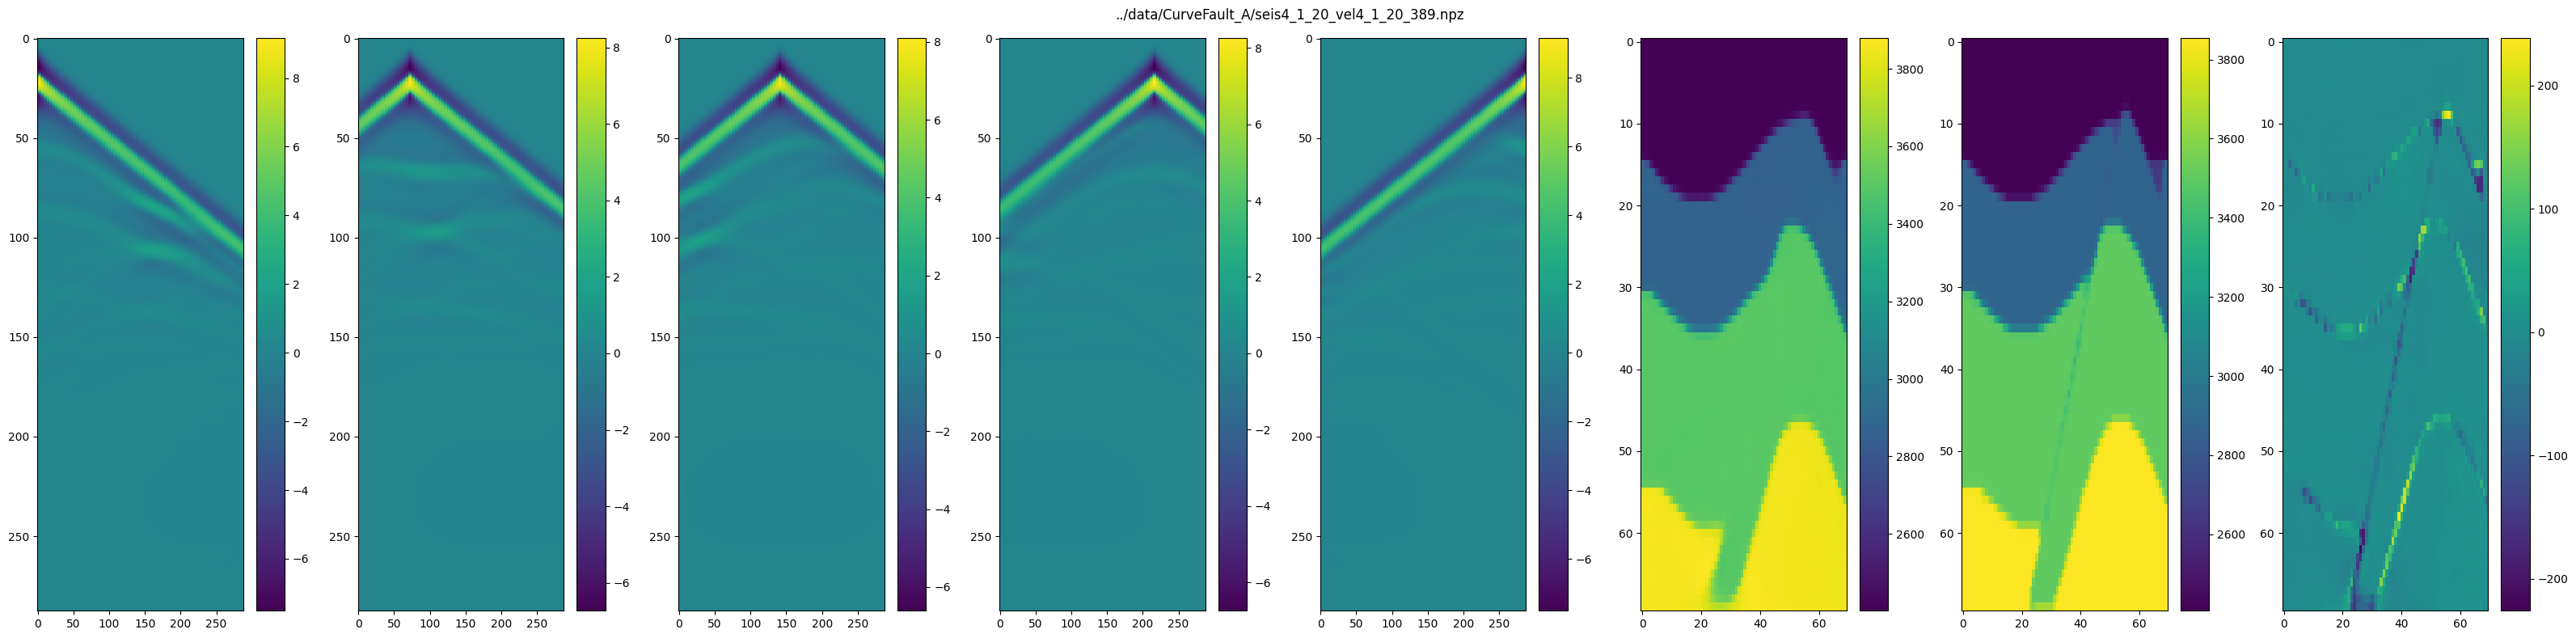

tensor([[21564,     2,    31,     3,     0],
        [    7, 11993,     0,     0,     0],
        [    9,     0, 21573,    18,     0],
        [    0,     0,     2, 11998,     0],
        [    0,     0,     0,     0, 26800]])
Test MAE: 48.0265
# of test data: 94000
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_f1_epoch         0.9989820718765259
    test_loss1_epoch         48.0265194121139
    test_loss2_epoch       0.002795959822833538
     test_loss_epoch         48.02931537245399
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
CPU times: user 15h 42min 18s, sys: 25min 4s, total: 16h 7min 23s
Wall time: 15h 49min 20s


In [11]:
%%time


print(statistics["All"]["mean_y"], statistics["All"]["std_y"])

model = LitUNetModel(
    model_name=config.model_name,
    pretrained=config.pretrained,
    num_classes=5,
    height=config.height,
    width=config.width,
    learning_rate=1e-04,
    mean_y=mean_y.to(config.device),
    std_y=std_y.to(config.device),
)

datamodule = MyDataModule(
    train_paths=train_paths,
    valid_paths=valid_paths,
    test_paths=test_paths,
    seed=config.seed,
    batch_size=config.batch_size,
    height=config.height,
    width=config.width,
    mean_x=mean_x,
    std_x=std_x,
    mean_y=None,
    std_y=None,
)

callbacks=[
    EarlyStopping(monitor="val_loss", patience=config.patience, mode='min'),
    LearningRateMonitor(logging_interval="step"),
    TQDMProgressBar(),
    # StochasticWeightAveraging(
    #     swa_lrs=1e-5,
    #     swa_epoch_start=int(0.8*config.epochs),
    #     annealing_epochs=int(0.2*config.epochs),
    # ),
]

trainer = L.Trainer(
    default_root_dir=config.output_dir,
    enable_checkpointing=False,
    accelerator="cuda" if torch.cuda.is_available() else "cpu",
    max_epochs=config.epochs,
    precision="bf16-mixed",
    callbacks=callbacks,
    logger=CSVLogger(config.output_dir, name="All"),
    log_every_n_steps=150,
    val_check_interval=None,
    check_val_every_n_epoch=1,
    accumulate_grad_batches=config.accumulation_steps,
    gradient_clip_val=0,
)

trainer.fit(model, datamodule=datamodule)
trainer.test(model, datamodule=datamodule)

checkpoint_path = config.output_dir.joinpath(f"All/multitask_v2_All_{config.seed}.ckpt")
trainer.save_checkpoint(checkpoint_path)

del datamodule
del callbacks
del trainer

,epoch,lr-AdamW,step,test_f1_epoch,test_f1_step,test_loss1_epoch,test_loss1_step,test_loss2_epoch,test_loss2_step,test_loss_epoch,...,train_loss_epoch,train_loss_step,val_f1_epoch,val_f1_step,val_loss1_epoch,val_loss1_step,val_loss2_epoch,val_loss2_step,val_loss_epoch,val_loss_step
0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.760318,NaN,193.538017,NaN,0.406585,NaN,193.944602
1,NaN,NaN,0,NaN,1.0,NaN,47.725109,NaN,0.000381,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.796522,NaN,162.831999,NaN,0.512002,NaN,163.344001
3,NaN,NaN,1,NaN,1.0,NaN,53.066820,NaN,0.000343,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.890070,NaN,205.850546,NaN,0.195614,NaN,206.046160


,epoch,val_loss_epoch
12461,0.0,182.905229
21989,1.0,123.370718
26817,2.0,96.902274
26944,3.0,80.316241
27072,4.0,70.600184
27199,5.0,60.979721
27326,6.0,55.318582
27454,7.0,51.699291
27581,8.0,48.549563
27708,9.0,48.079294


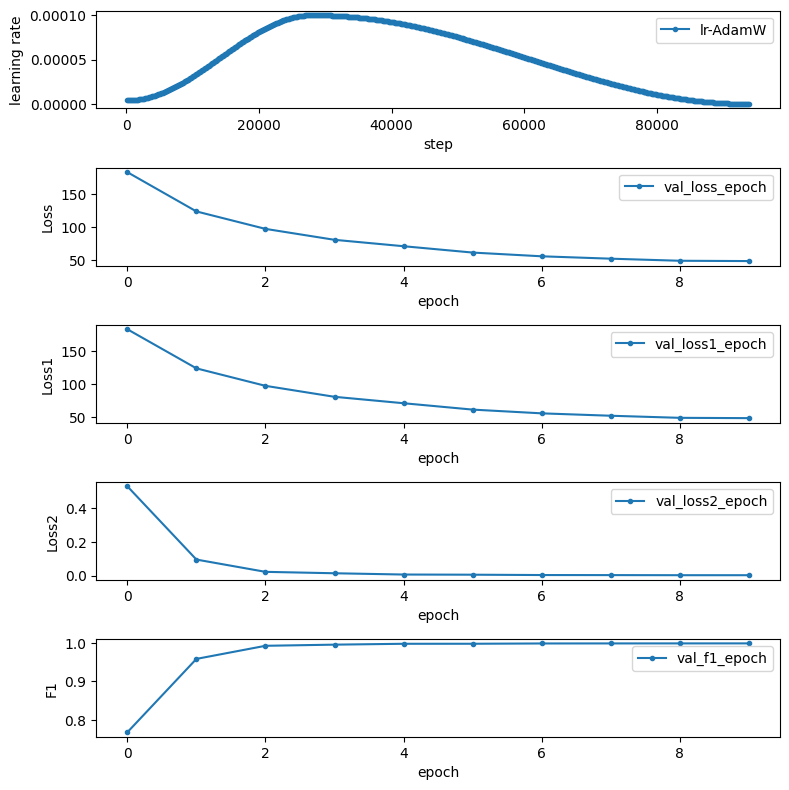

In [12]:
metrics0 = pd.read_csv(config.output_dir.joinpath(f"All/version_0/metrics.csv"))
metrics0 = metrics0.sort_values(["step", "epoch"]).reset_index(drop=True)
display(metrics0.head())
display(metrics0[["epoch", "val_loss_epoch"]].dropna())

_, axs = plt.subplots(5, 1, figsize=(8, 8))
metrics0[["step", "lr-AdamW"]].dropna().plot(x="step", y="lr-AdamW", kind="line", marker=".", ax=axs[0])
metrics0[["epoch", "val_loss_epoch"]].dropna().plot(x="epoch", y="val_loss_epoch", kind="line", marker=".", ax=axs[1])
metrics0[["epoch", "val_loss1_epoch"]].dropna().plot(x="epoch", y="val_loss1_epoch", kind="line", marker=".", ax=axs[2])
metrics0[["epoch", "val_loss2_epoch"]].dropna().plot(x="epoch", y="val_loss2_epoch", kind="line", marker=".", ax=axs[3])
metrics0[["epoch", "val_f1_epoch"]].dropna().plot(x="epoch", y="val_f1_epoch", kind="line", marker=".", ax=axs[4])
axs[0].set_xlabel("step")
axs[0].set_ylabel("learning rate")
axs[1].set_xlabel("epoch")
axs[1].set_ylabel("Loss")
axs[2].set_xlabel("epoch")
axs[2].set_ylabel("Loss1")
axs[3].set_xlabel("epoch")
axs[3].set_ylabel("Loss2")
axs[4].set_xlabel("epoch")
axs[4].set_ylabel("F1")
plt.tight_layout()
plt.show()

### Test

In [ ]:
from util.log_transform import log_transform_torch
    

class InferenceDataset(Dataset):
    def __init__(
            self,
            paths: List[Path],
            height: int,
            width: int,
            mean_x: torch.Tensor,
            std_x: torch.Tensor,
        ) -> None:
        
        self.paths = paths
        self.height = height
        self.width = width
        self.mean_x = mean_x
        self.std_x = std_x
    
    def __len__(self) -> int:
        return len(self.paths)
    
    def __getitem__(self, index: int) -> Tuple[str, torch.Tensor]:
        path = self.paths[index]
        file_names = path.stem
        x = np.load(path)["x"] # (5, 1000, 70)
        x = torch.from_numpy(x)
        x = log_transform_torch(x)
        x = (x - self.mean_x) / self.std_x
        x = x.unsqueeze(dim=0) # (1, 5, 1000, 70)
        x = F.interpolate(x, size=(self.height, self.width), mode="nearest")
        x = x.squeeze(dim=0) # (5, 1000, 70)
        x = x.float()
        return file_names, x

In [14]:
display(pd.crosstab(test_paths["family"], test_paths["label"]))

label,0,1,2,3,4
family,,,,,
CurveFault_A,10800,0,0,0,0
CurveFault_B,10800,0,0,0,0
CurveVel_A,0,6000,0,0,0
CurveVel_B,0,6000,0,0,0
FlatFault_A,0,0,10800,0,0
FlatFault_B,0,0,10800,0,0
FlatVel_A,0,0,0,6000,0
FlatVel_B,0,0,0,6000,0
Style_A,0,0,0,0,13400


0 torch.Size([1, 128, 72, 72])
1 torch.Size([1, 256, 36, 36])
2 torch.Size([1, 512, 18, 18])
3 torch.Size([1, 1024, 9, 9])
cuda:0


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

torch.Size([94000, 1, 70, 70]) tensor(1054.9710, dtype=torch.float64) tensor(4936.6255, dtype=torch.float64)
[18625 42611 77885 30309  7519]


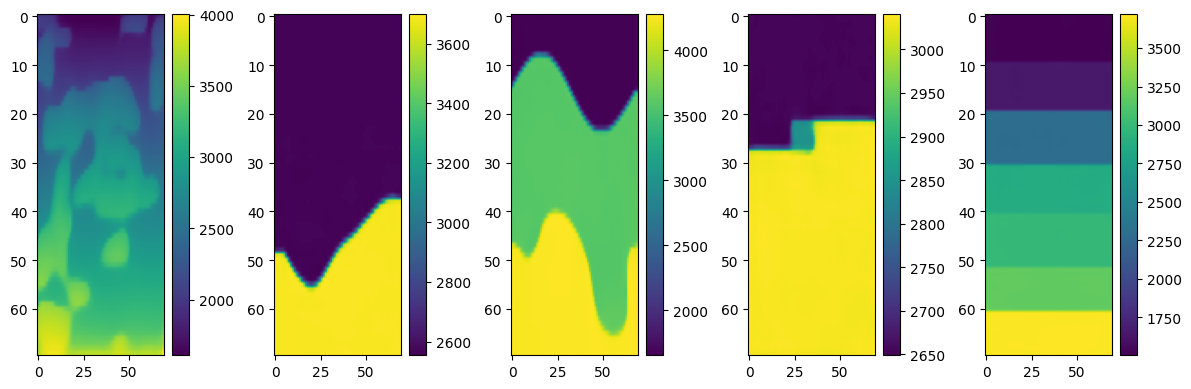

In [15]:
checkpoint_path = config.output_dir.joinpath(f"All/multitask_v2_All_{config.seed}.ckpt")

model = LitUNetModel.load_from_checkpoint(checkpoint_path)
model.eval()

model.to("cuda")
print(model.device)

test_dataset = InferenceDataset(
    paths=list(test_paths["path"]),
    height=config.height,
    width=config.width,
    mean_x=mean_x,
    std_x=std_x,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=os.cpu_count()//8,
    pin_memory=False,
)

trainer = L.Trainer(
    default_root_dir=config.output_dir,
    enable_checkpointing=False,
    logger=False,
)
predictions = trainer.predict(model, test_dataloader)
test_file_names, test_reg_logits, test_clf_logits = zip(*predictions)
test_reg_logits = torch.cat(test_reg_logits)
test_clf_logits = torch.cat(test_clf_logits)
print(test_reg_logits.shape, test_reg_logits.min(), test_reg_logits.max())

random_index = np.random.choice(range(len(test_dataset)), size=5, replace=False)
print(random_index)

_, axs = plt.subplots(1, 5, figsize=(12, 4))
for e, i in enumerate(random_index):
    img = axs[e].imshow(test_reg_logits[i, 0], aspect="auto")
    plt.colorbar(img, ax=axs[e])
plt.tight_layout()
plt.show()

### Compute the confusion matrix and F1 Score

In [16]:
test_paths["pred_label"] = torch.argmax(test_clf_logits, dim=1)
display(test_paths)

cm = multiclass_confusion_matrix(
    torch.Tensor(test_paths["pred_label"].values),
    torch.Tensor(test_paths["label"].values),
    num_classes=5,
)
display(cm)

f1 = multiclass_f1_score(
    torch.Tensor(test_paths["pred_label"].values),
    torch.Tensor(test_paths["label"].values),
    num_classes=5,
    average="macro",
)
display(f1)

,family,label,path,pred_label
15254,CurveFault_A,0,../data/CurveFault_A/seis4_1_20_vel4_1_20_389.npz,0
391416,Style_A,4,../data/Style_A/data6_model6_428.npz,4
298272,FlatVel_A,3,../data/FlatVel_A/data28_model28_53.npz,3
367110,Style_A,4,../data/Style_A/data23_model23_212.npz,4
282748,FlatVel_A,3,../data/FlatVel_A/data51_model51_236.npz,3
...,...,...,...,...
208071,FlatFault_A,2,../data/FlatFault_A/seis4_1_21_vel4_1_21_143.npz,2
391973,Style_A,4,../data/Style_A/data54_model54_176.npz,4
113001,CurveVel_A,1,../data/CurveVel_A/data41_model41_116.npz,1
417303,Style_B,4,../data/Style_B/data28_model28_8.npz,4


tensor([[21564,     2,    31,     3,     0],
        [    7, 11993,     0,     0,     0],
        [    9,     0, 21573,    18,     0],
        [    0,     0,     2, 11998,     0],
        [    0,     0,     0,     0, 26800]])

tensor(0.9992)

### Compute the MAE for each class

In [17]:
test_paths.reset_index(drop=True)

,family,label,path,pred_label
0,CurveFault_A,0,../data/CurveFault_A/seis4_1_20_vel4_1_20_389.npz,0
1,Style_A,4,../data/Style_A/data6_model6_428.npz,4
2,FlatVel_A,3,../data/FlatVel_A/data28_model28_53.npz,3
3,Style_A,4,../data/Style_A/data23_model23_212.npz,4
4,FlatVel_A,3,../data/FlatVel_A/data51_model51_236.npz,3
...,...,...,...,...
93995,FlatFault_A,2,../data/FlatFault_A/seis4_1_21_vel4_1_21_143.npz,2
93996,Style_A,4,../data/Style_A/data54_model54_176.npz,4
93997,CurveVel_A,1,../data/CurveVel_A/data41_model41_116.npz,1
93998,Style_B,4,../data/Style_B/data28_model28_8.npz,4


CurveFault_A


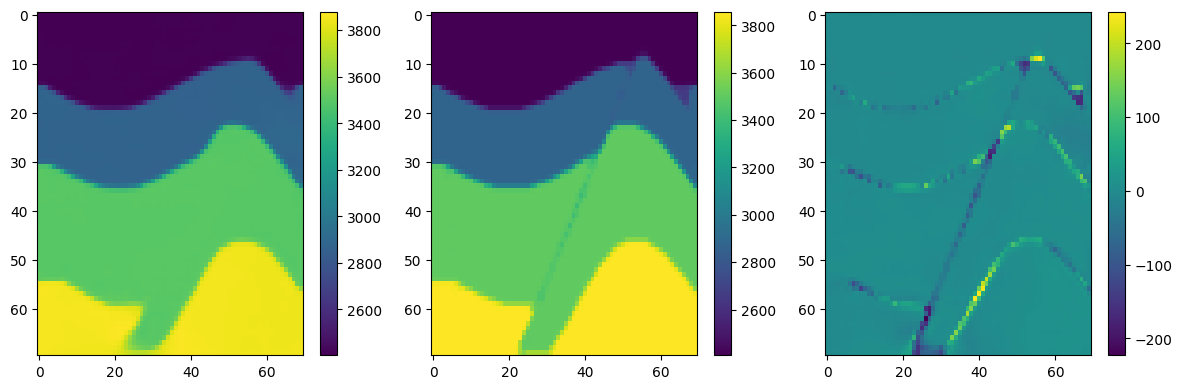

MAE: 13.3215
CurveFault_B


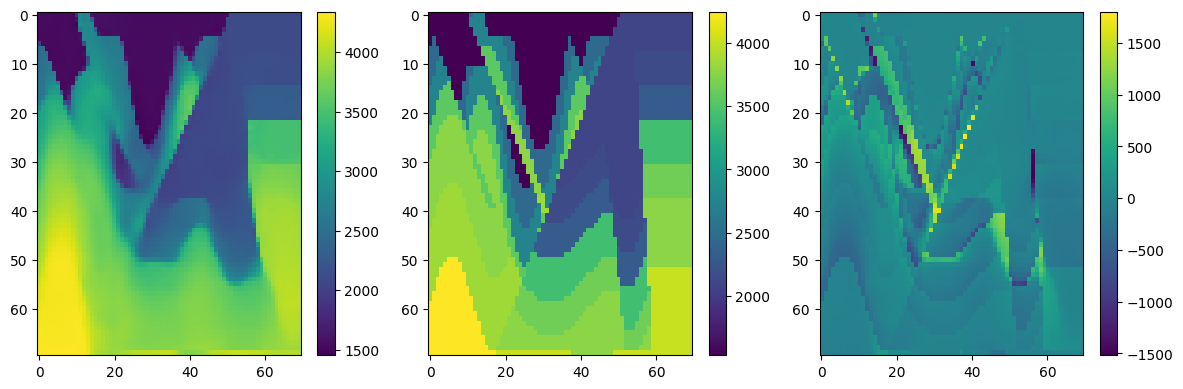

MAE: 127.3039
CurveVel_A


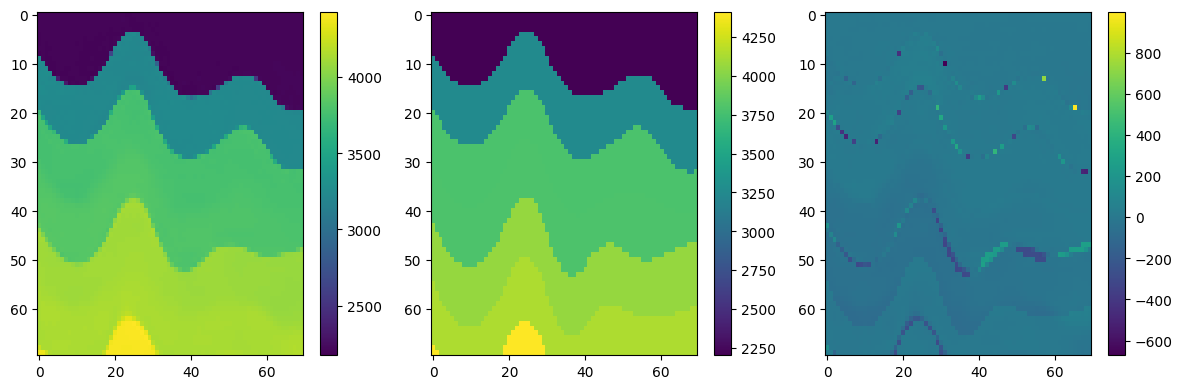

MAE: 26.2547
CurveVel_B


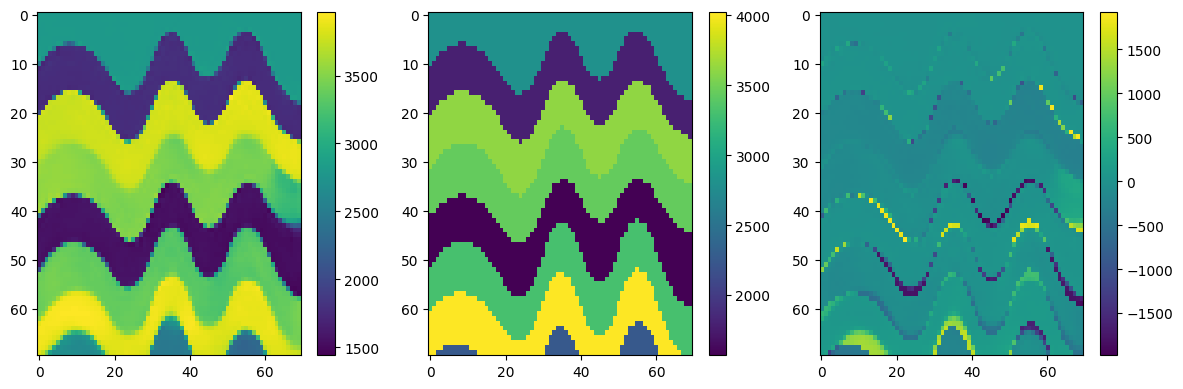

MAE: 79.4058
FlatFault_A


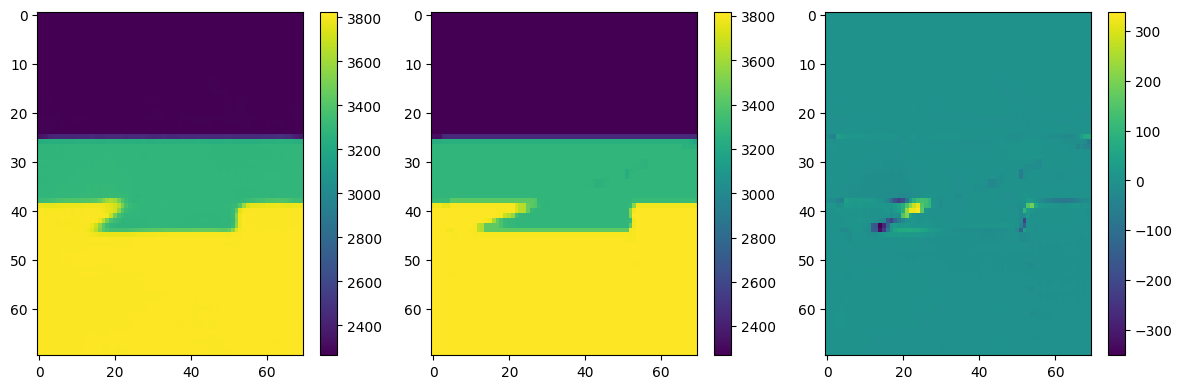

MAE: 7.9803
FlatFault_B


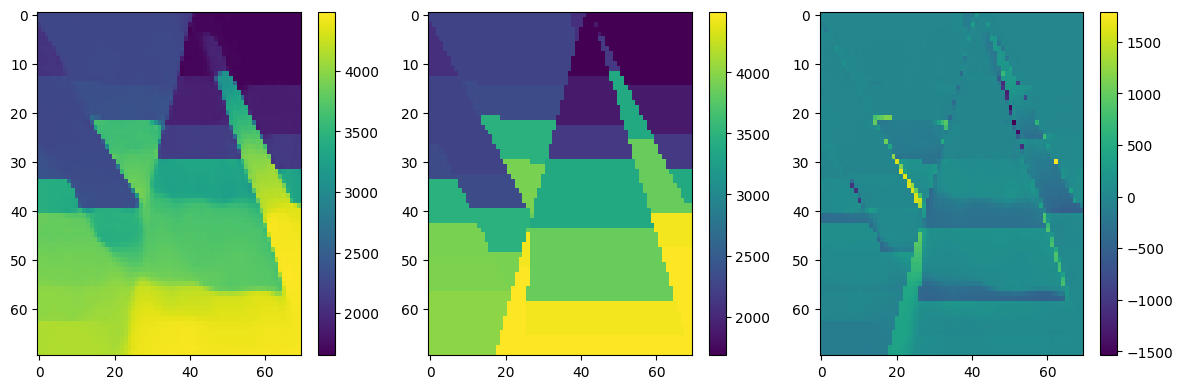

MAE: 58.9702
FlatVel_A


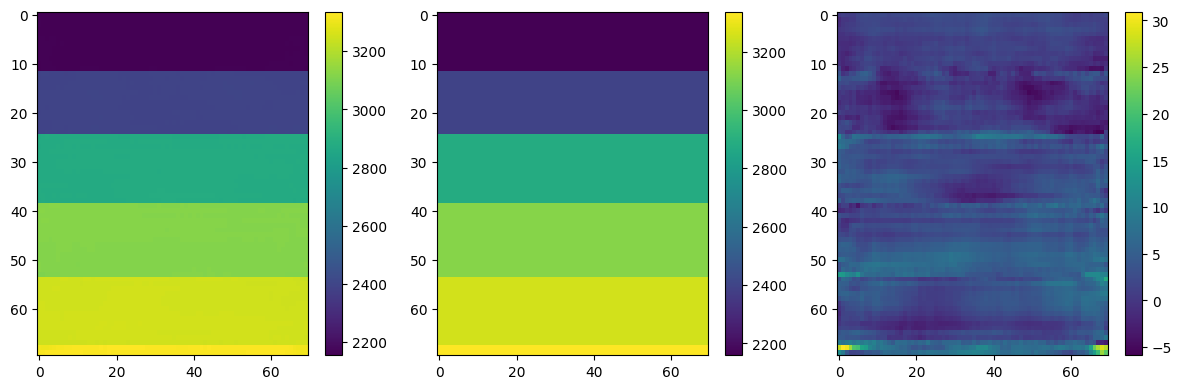

MAE: 4.4653
FlatVel_B


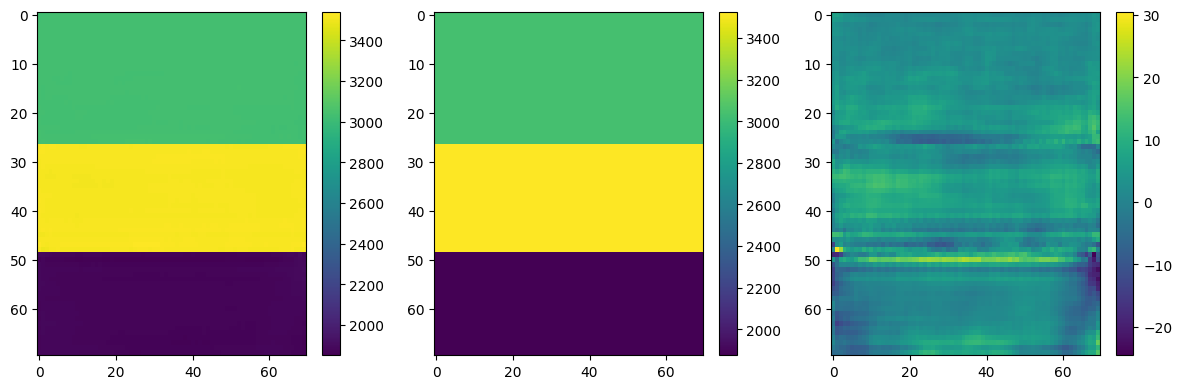

MAE: 17.9751
Style_A


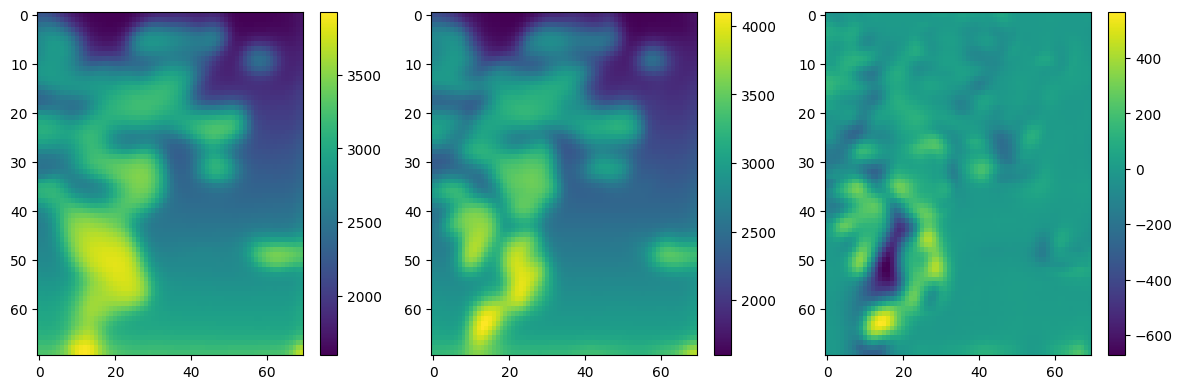

MAE: 48.7423
Style_B


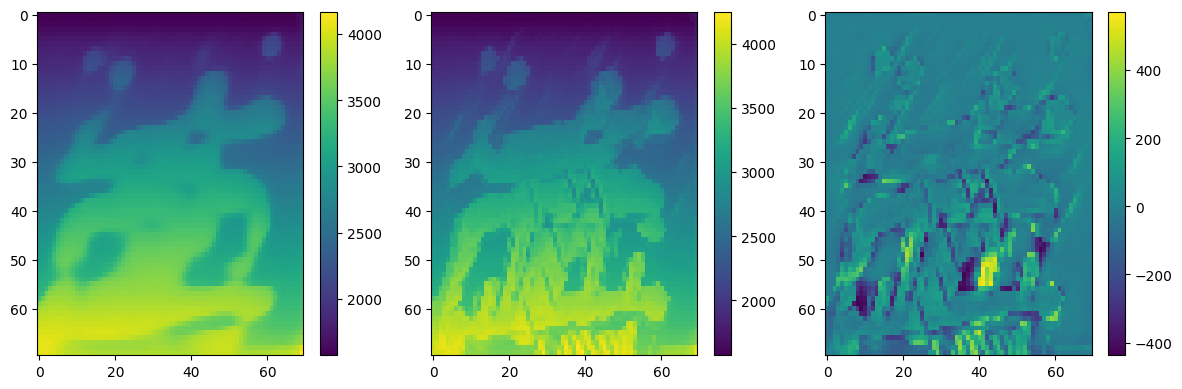

MAE: 64.0253
All MAE: 48.1012


In [18]:
count = 0
mae_all = 0
for g_name, g in test_paths.reset_index(drop=True).groupby("family"):
    print(g_name)
    idx = g.index.to_list()
    g_reg_images = test_reg_logits[idx]
    g_true_images = [np.load(p)["y"] for p in g["path"]]
    g_true_images = np.stack(g_true_images, axis=0)
    g_true_images = torch.Tensor(g_true_images)
    # g_true_images = (g_true_images - statistics["All"]["mean_y"]) / statistics["All"]["std_y"]
    # g_true_images = g_true_images * statistics["All"]["std_y"] + statistics["All"]["mean_y"]
    
    _, axs = plt.subplots(1, 3, figsize=(12, 4))
    img0 = axs[0].imshow(g_reg_images[0, 0], aspect="auto")
    img1 = axs[1].imshow(g_true_images[0, 0], aspect="auto")
    img2 = axs[2].imshow(g_true_images[0, 0]-g_reg_images[0, 0], aspect="auto")
    plt.colorbar(img0, ax=axs[0])
    plt.colorbar(img1, ax=axs[1])
    plt.colorbar(img2, ax=axs[2])
    plt.tight_layout()
    plt.show()

    mae = F.l1_loss(
        g_reg_images,
        g_true_images,
        reduction="sum",
    )
    mae_all += mae.item()
    print(f"MAE: {mae.item() / len(g) / 70 / 70:.4f}")
    print("="*50)

mae_all = mae_all / len(test_paths) / 70 / 70
print(f"All MAE: {mae_all:.4f}")

### Export logs as HTML file

In [ ]:
os.system(f"jupyter nbconvert --to html --output-dir {config.output_dir} 3_train_multitask_using_AB.ipynb")

[NbConvertApp] Converting notebook 3_train_multitask_v2.ipynb to html
[NbConvertApp] Writing 422866 bytes to ../output/multitask_v2_2025-05-23-01-58/3_train_multitask_v2.html


0

In [20]:
test_paths.drop(columns=["pred_label"], inplace=True)

0 torch.Size([1, 128, 72, 72])
1 torch.Size([1, 256, 36, 36])
2 torch.Size([1, 512, 18, 18])
3 torch.Size([1, 1024, 9, 9])


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


cuda:0


Testing: |          | 0/? [00:00<?, ?it/s]

/home/ss/kaggle_work/.venv/lib/python3.11/site-packages/pytorch_lightning/core/module.py:512: You called `self.log('test_loss1', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/ss/kaggle_work/.venv/lib/python3.11/site-packages/pytorch_lightning/core/module.py:512: You called `self.log('test_loss2', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/ss/kaggle_work/.venv/lib/python3.11/site-packages/pytorch_lightning/core/module.py:512: You called `self.log('test_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/home/ss/kaggle_work/.venv/lib/python3.11/site-packages/pytorch_lightning/core/module.py:512: You called `self.log('test_f1', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


../data/CurveFault_A/seis4_1_20_vel4_1_20_389.npz


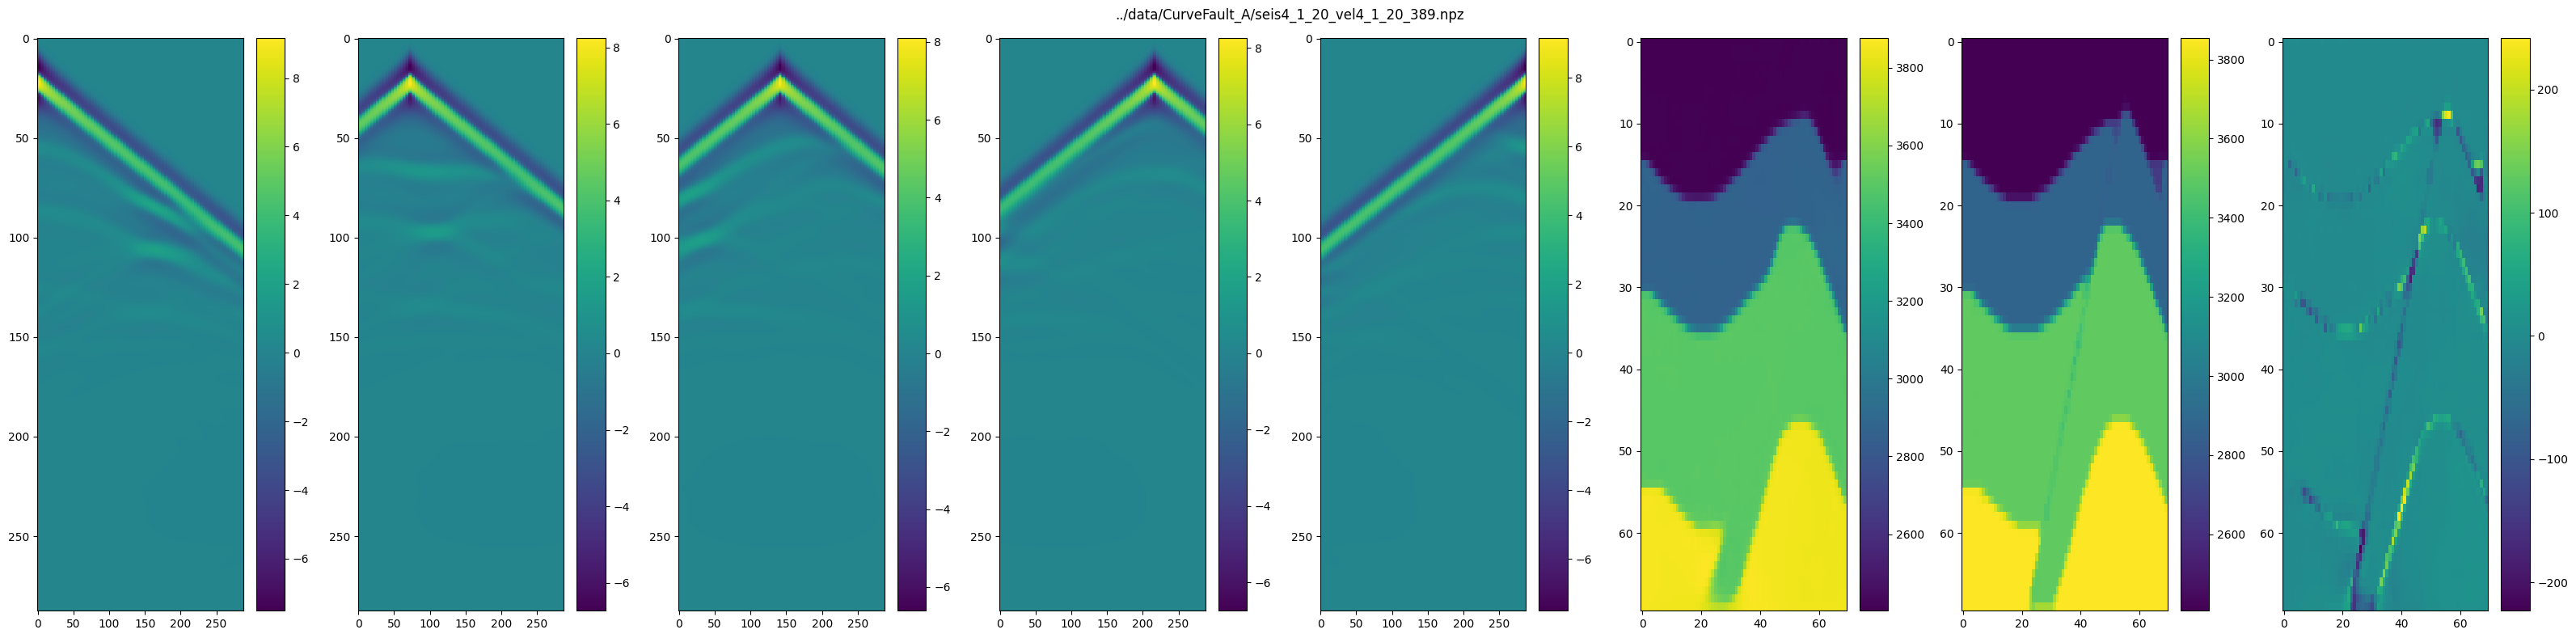

tensor([[21564,     2,    31,     3,     0],
        [    7, 11993,     0,     0,     0],
        [    9,     0, 21573,    18,     0],
        [    0,     0,     2, 11998,     0],
        [    0,     0,     0,     0, 26800]])
Test MAE: 48.0939
# of test data: 94000
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_f1_epoch         0.9989820718765259
    test_loss1_epoch         48.09389017385161
    test_loss2_epoch       0.002796710701659322
     test_loss_epoch        48.096686884736656
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss1_epoch': 48.09389017385161,
  'test_loss2_epoch': 0.002796710701659322,
  'test_loss_epoch': 48.096686884736656,
  'test_f1_epoch': 0.9989820718765259}]

In [21]:
checkpoint_path = config.output_dir.joinpath(f"All/multitask_v2_All_{config.seed}.ckpt")

model = LitUNetModel.load_from_checkpoint(checkpoint_path)
model.eval()

model.to(config.device)
print(model.device)

datamodule = MyDataModule(
    train_paths=train_paths,
    valid_paths=valid_paths,
    test_paths=test_paths,
    seed=config.seed,
    batch_size=config.batch_size,
    height=config.height,
    width=config.width,
    mean_x=mean_x,
    std_x=std_x,
    mean_y=None,
    std_y=None,
)

trainer = L.Trainer(
    default_root_dir=config.output_dir,
    enable_checkpointing=False,
    logger=False,
)

trainer.test(model, datamodule)

In [22]:
image = np.load("../data/FlatFault_A/seis2_1_4_vel2_1_4_364.npz")
x = torch.from_numpy(image["x"]).float()
x = log_transform_torch(x)
print(x.shape, mean_x.shape, std_x.shape)

x = (x - mean_x) / std_x
x = x.unsqueeze(dim=0)
x = F.interpolate(x, (config.height, config.width), mode="nearest")
print(x.shape)
x = x.float()

y = image["y"].astype(np.float32)

x = x.to(config.device)

model = model.to(config.device)
model.eval()
reg, clf = model(x)

# reg = reg * statistics["All"]["std_y"] + statistics["All"]["mean_y"]
reg = reg.cpu().detach().numpy()
clf = clf.cpu().detach().numpy()
print(reg.shape, clf.shape)

torch.Size([5, 1000, 70]) torch.Size([5, 1, 1]) torch.Size([5, 1, 1])
torch.Size([1, 5, 288, 288])
(1, 1, 70, 70) (1, 5)


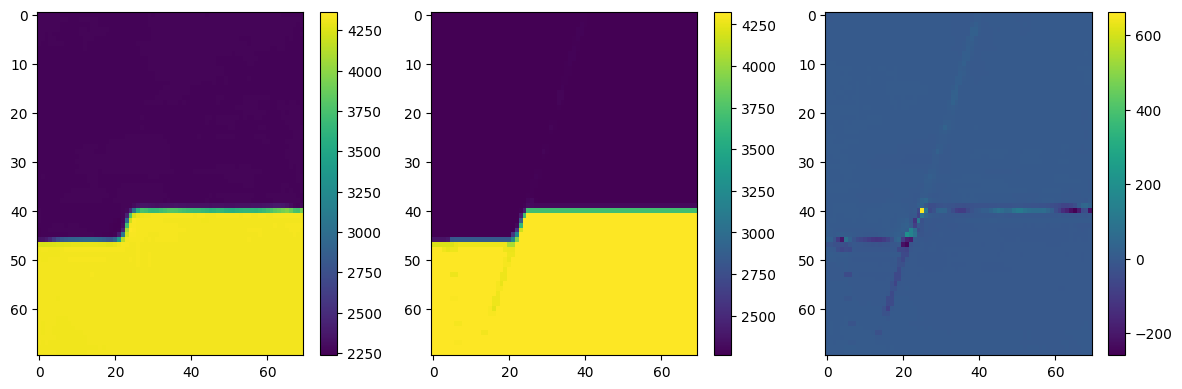

In [23]:
_, axs = plt.subplots(1, 3, figsize=(12, 4))
img0 = axs[0].imshow(reg[0, 0], aspect="auto")
img1 = axs[1].imshow(y[0], aspect="auto")
img2 = axs[2].imshow(y[0]-reg[0, 0], aspect="auto")
plt.colorbar(img0, ax=axs[0])
plt.colorbar(img1, ax=axs[1])
plt.colorbar(img2, ax=axs[2])
plt.tight_layout()
plt.show()